In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
import pandas as pd
from tqdm import trange, tqdm
from scipy.optimize import linear_sum_assignment
import itertools

In [2]:
# Load data.
data = pd.read_csv('data_reduced.csv',index_col=0)
metadata = pd.read_csv('metadata_reduced.csv',index_col=0)

In [3]:
# Extract cells x gene matrix
Xraw = data.values

In [4]:
# Normalize the columns to unit variance
X = Xraw / np.std(Xraw, axis=0, keepdims=True)

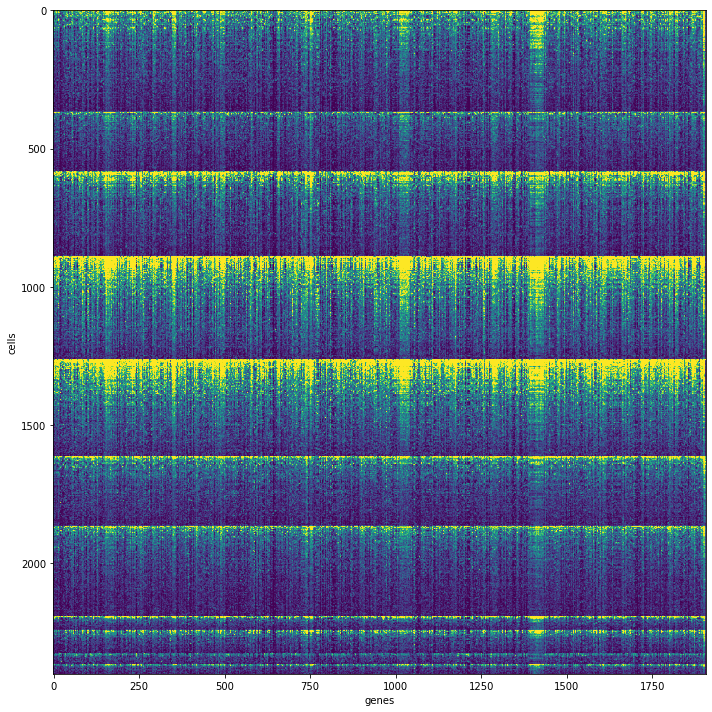

In [45]:
# Plot raw data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(X, aspect='auto', clim=(0, np.percentile(X, 90)))
ax.set_ylabel("cells")
ax.set_xlabel("genes")
fig.tight_layout()

In [6]:
def fit_nmf(k):
    """Fit NMF. Extract factor matrices."""
    nmf = NMF(k, init="random", max_iter=1000).fit(X)
    H = nmf.components_
    W = nmf.transform(X)
    loss = np.linalg.norm(X - W @ H) / np.linalg.norm(X)
    return W, H, loss

max_components = 6
num_repeats = 10
ranks = np.repeat(np.arange(1, max_components + 1), num_repeats)
jittered_ranks = np.random.randn(ranks.size)*.1 + ranks
models = []

for k in trange(1, max_components + 1):
    for r in range(num_repeats):
        models.append(fit_nmf(k))

100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Text(0, 0.5, 'reconstruction error')

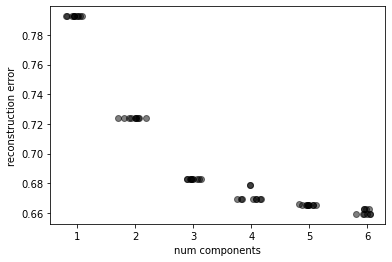

In [7]:
losses = [m[-1] for m in models]

fig, ax = plt.subplots(1, 1)
ax.scatter(jittered_ranks, losses, alpha=.5, color="k")
ax.set_xlabel("num components")
ax.set_ylabel("reconstruction error")

In [17]:
def stack_and_normalize_factors(model):
    W, H, _ = model
    return np.column_stack((
        ((1 / np.sqrt(2)) * W / np.linalg.norm(W, axis=0, keepdims=True)).T,
        ((1 / np.sqrt(2)) * H / np.linalg.norm(H, axis=1, keepdims=True))
    ))

def similarity(model_1, model_2):
    M1 = stack_and_normalize_factors(model_1)
    M2 = stack_and_normalize_factors(model_2)

    G = M1 @ M2.T
    ri, ci = linear_sum_assignment(G, maximize=True)
    return np.mean(G[ri, ci])

rank_combs = []
similarities = []
pbar = tqdm(total=(ranks.size * (ranks.size - 1))//2)

for (i, j) in itertools.combinations(range(ranks.size), 2):
    if ranks[i] == ranks[j]:
        rank_combs.append(ranks[i])
        similarities.append(
            similarity(models[i], models[j])
        )
    pbar.update(n=1)
rank_combs = np.array(rank_combs)
pbar.close()

100%|██████████| 1770/1770 [00:00<00:00, 15966.82it/s]


Text(0.5, 0, 'number of components')

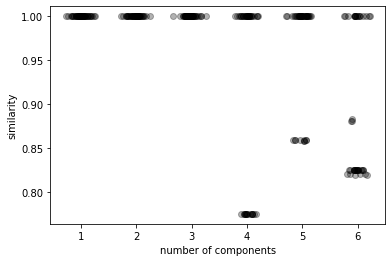

In [19]:
fig, ax = plt.subplots()
ax.scatter(rank_combs + np.random.randn(rank_combs.size)*.1, similarities, color="k", alpha=.3)
ax.set_ylabel("similarity")
ax.set_xlabel("number of components")

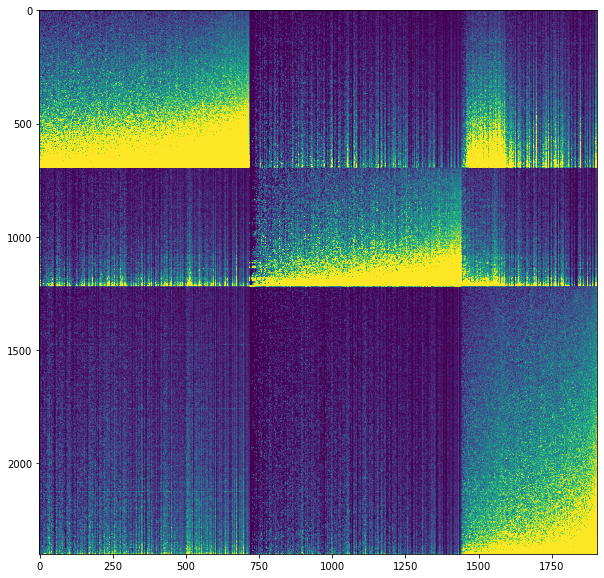

In [44]:
def sort_factor(M):
    i = np.argmax(M, axis=1)
    j = M[np.arange(M.shape[0]), i]
    return np.lexsort(np.row_stack((j, i)))

W, H, _ = models[25]

ii, jj = sort_factor(W), sort_factor(H.T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(X[ii][:, jj], aspect="auto", clim=(0, np.percentile(X, 90)))

[]

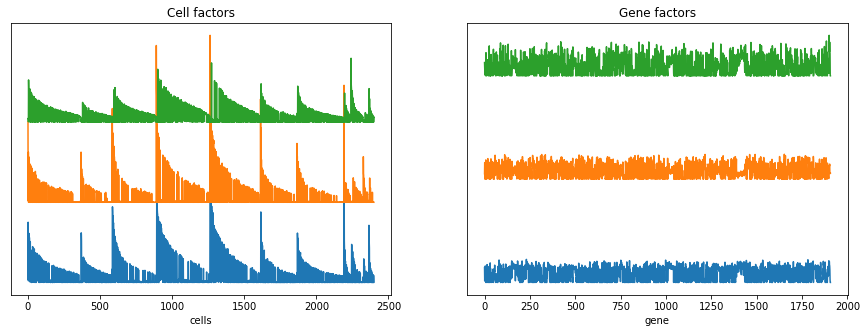

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(W + np.linspace(0, 10, W.shape[1]))
axes[0].set_title("Cell factors")
axes[0].set_xlabel("cells")
axes[0].set_yticks([])

axes[1].plot(H.T + np.linspace(0, 10, H.shape[0]))
axes[1].set_title("Gene factors")
axes[1].set_xlabel("gene")
axes[1].set_yticks([])

[]

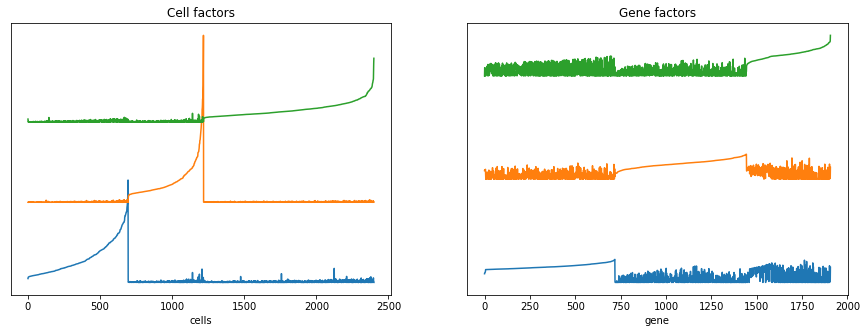

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(W[ii] + np.linspace(0, 10, W.shape[1]))
axes[0].set_title("Cell factors")
axes[0].set_xlabel("cells")
axes[0].set_yticks([])

axes[1].plot(H.T[jj] + np.linspace(0, 10, H.shape[0]))
axes[1].set_title("Gene factors")
axes[1].set_xlabel("gene")
axes[1].set_yticks([])